In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
from __future__ import print_function
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import AlphaDropout
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
# Add the swish function to Keras
import tensorflow as tf
from tensorflow.keras.activations import softplus, tanh, sigmoid, softplus, elu, selu, relu, softsign, hard_sigmoid
from tensorflow.keras.layers import Activation
from tensorflow.keras.backend import sin
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import ThresholdedReLU


#learnable param
# beta=tf.Variable(0.1)
# def swish(x):
#     return x*tf.math.sigmoid(beta*x)
# get_custom_objects().update({'Swish':Activation(swish)})

from tensorflow.keras.activations import sigmoid, relu, tanh, softplus, selu, elu, softsign
def SoftClipping_Swish(x):
    return tf.maximum(0.0, swish(x))
get_custom_objects().update({'SC Swish':Activation(SoftClipping_Swish)})

def swish(x):
    return x*sigmoid(x)
get_custom_objects().update({'Swish':Activation(swish)})

act_func = ['sigmoid', 'tanh', 'relu', 'Swish', 'SC Swish']


In [ ]:
from tensorflow.keras.datasets import cifar100
# Load the CIFAR100 data.
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169017344/169001437 [==============================] - 13s 0us/step


In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0].shape, 'image shape')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
(32, 32, 3) image shape


In [ ]:

# Training parameters
# batch_size = 32  # orig paper trained all networks with batch_size=128
batch_size = 128
epochs = 100
data_augmentation = False
num_classes = 100

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True


def preprocess_cifar10(x_train, y_train, x_test, y_test):
    # Input image dimensions.
    input_shape = x_train.shape[1:]

    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)

    # Convert class vectors to binary class matrices.
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    
    return x_train, y_train, x_test, y_test, input_shape
    
x_train, y_train, x_test, y_test, input_shape = preprocess_cifar10(x_train, y_train, x_test, y_test)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-5
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
for activation in act_func:
    # LeNet-5 model
    class LeNet(Sequential):
        def __init__(self, input_shape, nb_classes):
            super().__init__()

            self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation=activation, input_shape=input_shape, padding="same"))
            self.add(BatchNormalization())
            self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
            self.add(BatchNormalization())
            self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation=activation, padding='valid'))
            self.add(BatchNormalization())
            self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
            self.add(Flatten())
            self.add(Dense(120, activation=activation))
            self.add(Dropout(0.2))
            self.add(Dense(84, activation=activation))
            self.add(Dense(nb_classes, activation='softmax'))

            self.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


In [ ]:
model = LeNet(x_train[0].shape, num_classes)

In [ ]:
model.summary()

Model: "le_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 6)        0         
 ooling2D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 6)        24        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                            

In [ ]:
import datetime
# Place the logs in a timestamped subdirectory
# This allows to easy select different training runs
# In order not to overwrite some data, it is useful to have a name with a timestamp
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Specify the callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# tf.keras.callback.TensorBoard ensures that logs are created and stored
# We need to pass callback object to the fit method
# The way to do this is by passing the list of callback objects, which is in our case just one

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

version=5
depth=8
# Model name, depth and version
model_type = 'LeNet%dv%d' % (depth, version)

# Prepare callbacks for model saving and for learning rate adjustment.
earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              min_delta=0, 
                              patience=5, 
                              verbose=0, mode='auto', 
                              baseline=None, 
                              restore_best_weights=True)
#path to save the checkpoints
filepath="saved_models/Cifar10-LeNet5-{epoch:02d}-{val_accuracy:.2f}.hdf5"

#save checkpoint
checkpoint = ModelCheckpoint(filepath,monitor = "val_accuracy",verbose = 1, save_weights_only= True, save_best_only =True, mode = 'max')
lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
tb=TensorBoard(log_dir='./logs', 
               histogram_freq=0, 
               write_graph=True, 
               write_grads=False, 
               write_images=True, 
               embeddings_freq=0, 
               embeddings_layer_names=None,
               embeddings_metadata=None, embeddings_data=None, update_freq='epoch')


callbacks = [earlyStopping, lr_scheduler, tb]

In [ ]:
result = []
final_acc = []
final_loss = []
name=[]
for activation in act_func:
    print('\nTraining with -->{0}<-- activation function\n'.format(activation))
#     model = model(activation=activation,
#                               input_shape=input_shape,
#                               depth=depth)
    # Run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  callbacks=callbacks)
        result.append(history)
        final_acc.append(history.history['val_accuracy'][-1])
        final_loss.append(history.history['val_loss'][-1])
        name.append(activation)
        
        print('{} \n val loss: {}, val acc: {}\n'.format(activation,history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        history = datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            validation_data=(x_test, y_test),
                            epochs=epochs, verbose=1, workers=4,
                            callbacks=callbacks)
        result = result.append(history)
        final_acc = final_acc.append(history.history['val_accuracy'][-1])
        final_loss = final_loss.append(history.history['val_loss'][-1])
        name = name.append(activation)
        
        print('{} \n val loss: {}, val acc: {}\n'.format(activation,history.history['val_loss'][-1], history.history['val_accuracy'][-1]))

print(result)

# i=0


# a=0
# while(i<len(act_func)):
#     dict={name[i]: {final_acc[i], final_loss[i]}}
    
#     print(dict)
#     if i>0 and final_acc[i]>final_acc[i-1]:
#         a=final_acc[i]
#         nume=name[i]
#     i+=1
# print('Best acc made by function {} with acc of {}'.format(nume,a))

    


Training with -->sigmoid<-- activation function

Not using data augmentation.
Learning rate:  1e-05
Epoch 1/100
391/391 [==============================] - 15s 8ms/step - loss: 4.6882 - accuracy: 0.0106 - val_loss: 4.6069 - val_accuracy: 0.0100 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 2/100
391/391 [==============================] - 2s 6ms/step - loss: 4.6301 - accuracy: 0.0124 - val_loss: 4.5940 - val_accuracy: 0.0162 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 3/100
391/391 [==============================] - 2s 6ms/step - loss: 4.5955 - accuracy: 0.0179 - val_loss: 4.5669 - val_accuracy: 0.0257 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 4/100
391/391 [==============================] - 2s 6ms/step - loss: 4.5655 - accuracy: 0.0243 - val_loss: 4.5396 - val_accuracy: 0.0293 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 5/100
391/391 [==============================] - 2s 6ms/step - loss: 4.5353 - accuracy: 0.0302 - val_loss: 4.5118 - val_accuracy: 0.0335 - lr: 1.0000e-05
Learning r

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

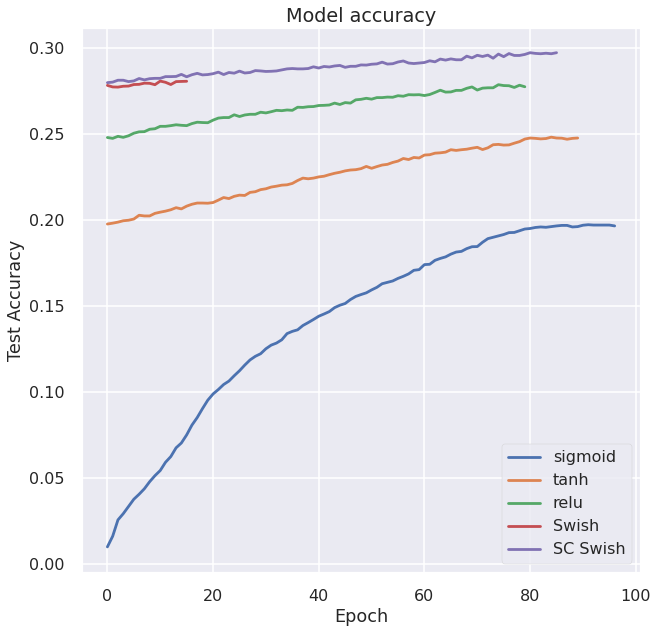

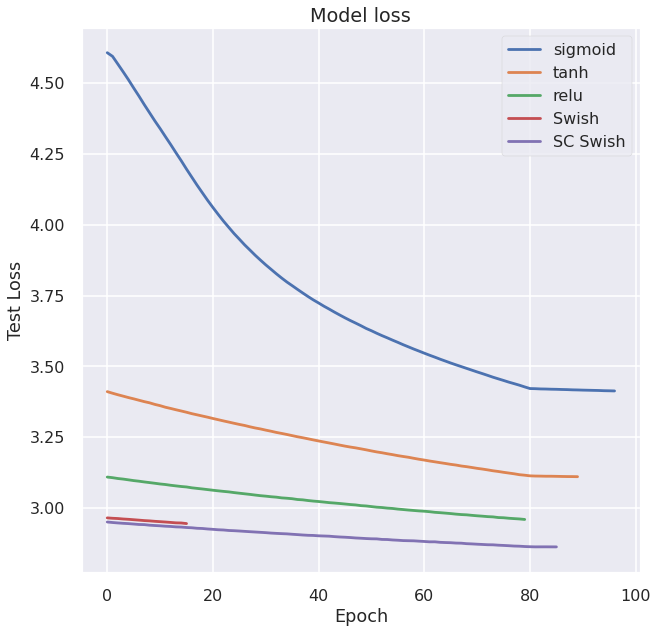

In [ ]:
import matplotlib.pyplot as plt
new_act_arr = act_func[0:]
new_results = result[0:]

def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-poster')
    
    # Plot validation accuracy values
    for act_func in results:
        plt.plot(act_func.history['val_accuracy'])
        
    plt.title('Model accuracy')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

    # Plot validation loss values
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_loss'])
        
    plt.title('Model loss')
    plt.ylabel('Test Loss')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

plot_act_func_results(new_results, new_act_arr)